# Age Classification Using Support Vector Machine
## Pipeline:
- Load data from train/val/test split
    - Resize data to uniform shape (150,150)
    - Normalise values to between 0 and 1 unsigned 8bit integers
    - Convert to grescale
    - Equalise histograms
- Extract features from data
    - LBP
    - Edges
    - HoG
- Train SVM on image features
    - X_train will contain the feature vectors of the images
    - y_train will contain the ages of each image
- When classifying a new image we:
    - Preprocess (reshape, greyscale, equalise histograms)
    - Extract features (LBP, edges, HoG)
    - Input the feature vector X_new to the SVM



In [1]:
# Imports
import pandas as pd
import numpy as np
import os
import cv2
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.exposure import rescale_intensity
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, log_loss, classification_report

## Load the data

### First load the data about the images and split it into for labels > or < 25

In [2]:
# Paths
train_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_train.csv'
train_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/train'

val_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_valid.csv'
val_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/valid'

test_csv_path = '/Users/sambeattie/Documents/Level4Project/appa-real-release/gt_avg_test.csv'
test_image_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/test'

# Load CSV and create labels
# 0 if under 25, 1 if over 25
age_type = 'real_age'

df_train = pd.read_csv(train_csv_path)
df_train['label'] = df_train[age_type].apply(lambda x: 1 if x > 25 else 0)
# print(df['file_name'][:10])
# print(df['label'][:10])
df_val = pd.read_csv(val_csv_path)
df_val['label'] = df_val[age_type].apply(lambda x: 1 if x > 25 else 0)

df_test = pd.read_csv(test_csv_path)
df_test['label'] = df_test[age_type].apply(lambda x: 1 if x > 25 else 0)

### Now we load a stratified batch of images

In [3]:
# Stratified batch generator to ensure even split of classes (under 25 and over 25)
# Loads and preprocesses images
def stratified_batch_generator(df, image_dir, batch_size=32, img_size=(150, 150)):
    while True:
        n_per_class = batch_size // 2 

        # Sample half the batch size from each class
        batch_under_25 = df[df['label'] == 0].sample(n=n_per_class, replace=False)
        batch_over_25 = df[df['label'] == 1].sample(n=n_per_class, replace=False)

        # Combine the samples
        batch_df = pd.concat([batch_under_25, batch_over_25])

        batch_images, batch_labels = [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(image_dir, row['file_name']+'_face.jpg')
            img = cv2.imread(img_path)
            if img is not None:
                # Preprocess Image:
                # Resize
                img = resize(img, img_size)
                
                # Normalise
                img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
                
                # Convert to greyscale
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Equalise histograms
                img = cv2.equalizeHist(img)

                batch_images.append(img)
                batch_labels.append(row['label'])

        # Convert to numpy arrays
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        # Shuffle the batch to mix the classes
        batch_images, batch_labels = shuffle(batch_images, batch_labels)
        yield batch_images, batch_labels


In [4]:
# Create generators for both train and val
batch_size = 600
img_size = (150, 150)
train_gen = stratified_batch_generator(df_train, train_image_dir, batch_size=1200, img_size=img_size)
val_gen = stratified_batch_generator(df_val, val_image_dir, batch_size=batch_size, img_size=img_size)
test_gen =  stratified_batch_generator(df_test, test_image_dir, batch_size=batch_size, img_size=img_size)
# Fetch one batch for train and val
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
# test_images, test_labels = next(test_gen)

In [5]:
train_size = train_labels.shape[0]
class_1_size = np.sum(train_labels==1)
class_0_size = np.sum(train_labels==0)
print("Train dataset info:")
print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
print(f"{class_1_size / train_size * 100}% split ")
print("============================")

val_size = val_labels.shape[0]
class_1_size = np.sum(val_labels==1)
class_0_size = np.sum(val_labels==0)
print("Val dataset info:")
print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
print(f"{class_1_size / val_size * 100}% split ")
print("============================")

# test_size = test_labels.shape[0]
# class_1_size = np.sum(test_labels==1)
# class_0_size = np.sum(test_labels==0)
# print("Test dataset info:")
# print(f"class 0 size: {class_0_size} / class 1 size: {class_1_size}")
# print(f"{class_1_size / val_size * 100}% split ")
# print("============================")

Train dataset info:
class 0 size: 600 / class 1 size: 600
50.0% split 
Val dataset info:
class 0 size: 300 / class 1 size: 300
50.0% split 


(1200, 150, 150) uint8


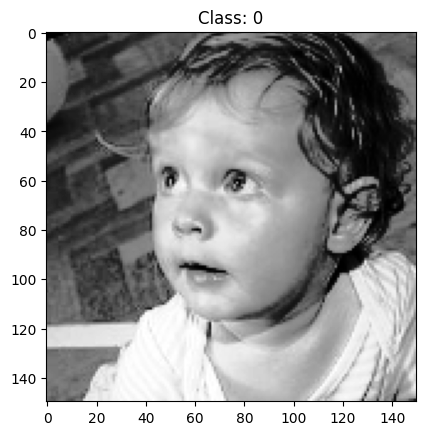

In [6]:
# Check shape and dtype of batch
ix = 0
print(train_images.shape, train_images.dtype)
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Class: {train_labels[ix]}")
plt.show()

# Feature Extraction

In [160]:
def extract_features(images_batch, feature):
    # Input: images_batch a (batch_size, 150, 150) numpy array containing one batch of images
    # Returns: X a matrix containing the feature vector specified for each image
    features = []

    lbp_radius = 3
    lbp_num_points = 8 * lbp_radius
    method='uniform'
    block_size = 50 

    
    hog_orientations=9
    hog_pixels_per_cell=(6, 6)
    hog_cells_per_block=(2, 2)

    for img in images_batch:

        if feature =='lbp':
            # Extract LBP
            # lbp = local_binary_pattern(img, lbp_num_points, lbp_radius, method=method).ravel()
            # features.append(lbp)
            
            lbp_histograms = []
            
            for i in range(0, img.shape[0], block_size):
                for j in range(0, img.shape[1], block_size):
                    block = img[i:i+block_size, j:j+block_size]
                    lbp = local_binary_pattern(block, lbp_num_points, lbp_radius, method=method)
                    # Calculate histogram for this block
                    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_num_points+3), range=(0, lbp_num_points+2))

                    lbp_histogram = lbp_histogram.astype("float")
                    lbp_histogram /= (lbp_histogram.sum() + 1e-7)  # Avoid division by zero

                    
                    lbp_histograms.append(lbp_histogram)
            
            features.append(np.concatenate(lbp_histograms))
            
        if feature == 'hog':
            # Extract Histogram of Oriented Gradients
            hog_feature_vec = hog(
                                img,
                                orientations=hog_orientations,
                                pixels_per_cell=hog_pixels_per_cell,
                                cells_per_block=hog_cells_per_block,
                                feature_vector=True,
                                )
            
            features.append(hog_feature_vec)
            
    X = np.array(features)
    return X

In [161]:
# Obtain X_train a (batch_size, feature_vector_size) matrix containing the feature vectors for each train image
# And y_train is just the class of each image (0 for under 25 / 1 for over 25)
feature_type = 'lbp'

X_train = extract_features(train_images, feature = feature_type)
y_train = train_labels
print(X_train.shape, y_train.shape)

# Same for X_val and y_val
X_val = extract_features(val_images, feature = feature_type)
y_val = val_labels
print(X_val.shape, y_val.shape)

# Same for X_test and y_test
# X_test = extract_features(test_images)
# y_test = test_labels
# print(X_test.shape, y_test.shape)

(1200, 54) (1200,)
(600, 54) (600,)


In [162]:
print(np.min(X_train), np.max(X_train), np.mean(X_train))
print(X_train[0])

0.0 0.9999999999600001 0.16666666666000005
[0.0468 0.1464 0.3892 0.2468 0.1388 0.032  0.066  0.1712 0.4036 0.2368
 0.0996 0.0228 0.0888 0.1956 0.3212 0.224  0.14   0.0304 0.0432 0.1576
 0.378  0.2652 0.122  0.034  0.038  0.1448 0.5044 0.2204 0.0708 0.0216
 0.0756 0.1824 0.3956 0.2032 0.1124 0.0308 0.076  0.174  0.298  0.2504
 0.154  0.0476 0.0472 0.156  0.4392 0.2396 0.0872 0.0308 0.0856 0.1688
 0.4036 0.198  0.1132 0.0308]


In [163]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=64)
# X_train = pca.fit_transform(X_train)
# X_val = pca.transform(X_val)
# # X_test_pca = pca.transform(X_test)

In [164]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

In [165]:
print(X_train.shape)
print(X_val.shape)
# print(X_test_pca.shape)

(1200, 54)
(600, 54)


# Fit the model to the data
Now that we have a feature vector X and the associated classes y, we can fit the SVM to create a hyperplane between the data

In [166]:
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}


# Create a support vector classifier
svc = svm.SVC(probability=True, class_weight='balanced')

cv = StratifiedKFold(n_splits=5)

# Create a model using GridSearchCV with the parameter grid
model = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy') 

In [167]:
# Train the model using the training data 
model.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [168]:
# Calculate validation accuracy
y_val_pred = model.best_estimator_.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Calculate validation loss
y_val_proba = model.best_estimator_.predict_proba(X_val)
val_loss = log_loss(y_val, y_val_proba)

print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation loss: {val_loss:.4f}")

Validation accuracy: 64.00%
Validation loss: 0.6392


In [53]:
success = np.where(y_test_pred == test_labels)[0]
fail = np.where(y_test_pred != test_labels)[0]
print(success.shape)
print(fail.shape)

NameError: name 'y_test_pred' is not defined

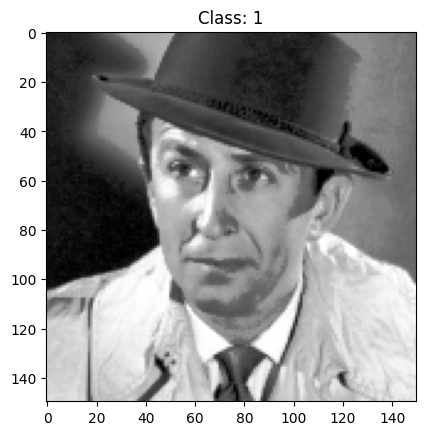

Image 2 is from class 1 and was predicted class 1


In [52]:
ix = fail[0]
plt.imshow(test_images[ix], cmap='gray')
plt.title(f"Class: {test_labels[ix]}")
plt.show()
print(f"Image {ix} is from class {test_labels[ix]} and was predicted class {y_test_pred[ix]}")

In [49]:
# Final test accuracy
y_test_pred = model.best_estimator_.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 64.06%
